<a href="https://colab.research.google.com/github/MoBanerjee/SC4001_Project/blob/main/ViT_FullFinetuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective of Notebook
### The objective of this notebook is to fine-tune all layers of a pre-trained ViT model on the Flowers102 dataset, applying early stopping based on validation accuracy, and evaluate its performance on the test set.

In [ ]:
# necessary imports
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize the image to 224x224 pixels
    transforms.ToTensor(),  # convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # normalize the image with ImageNet mean and std
])

In [ ]:
train_data = Flowers102(root='./data', split='train', transform=transform, download=True)  # load the training data with transformation applied
val_data = Flowers102(root='./data', split='val', transform=transform, download=True)  # load the validation data with transformation applied
test_data = Flowers102(root='./data', split='test', transform=transform, download=True)  # load the test data with transformation applied


In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)  # create data loader for training data, shuffle the data
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)  # create data loader for validation data, no shuffling
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)  # create data loader for test data, no shuffling

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # set device

In [ ]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=102, ignore_mismatched_sizes=True)  # load the pre-trained ViT model with 102 output labels
model.to(device)  # move the model to the specified device (GPU or CPU)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([102]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([102, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
criterion = nn.CrossEntropyLoss()  # define the loss function as cross-entropy for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)  # define the Adam optimizer with a learning rate of 2e-5 

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience  # set the number of epochs to wait for improvement before stopping
        self.verbose = verbose  # whether to print early stopping info
        self.counter = 0  # counter for epochs without improvement
        self.best_score = None  # variable to track the best score (e.g., validation accuracy)
        self.early_stop = False  # flag to indicate if early stopping should occur

    def __call__(self, score, epoch):
        if self.best_score is None:  # if there is no best score yet, set the first score as best
            self.best_score = score
        elif score < self.best_score:  # if the current score is worse than the best score
            self.counter += 1  # increment the counter for no improvement
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience} at epoch {epoch}')  # print the counter info
            if self.counter >= self.patience:  # if counter exceeds patience, trigger early stopping
                self.early_stop = True
                print(f'Early stopping at epoch {epoch}. No improvement in validation accuracy for {self.patience} consecutive epochs.')
        else:
            self.best_score = score  # update the best score
            self.counter = 0  # reset counter if improvement occurs


In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, model_save_path, epochs=5, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)  # initialize early stopping
    best_val_accuracy = 0.0  # variable to track the best validation accuracy
    best_model_wts = None  # variable to store the model's best weights

    # Lists to store loss and accuracy histories for training and validation
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []

    # Loop through each epoch
    for epoch in range(epochs):
        model.train()  # set the model to training mode
        running_loss = 0.0  # initialize running loss
        correct = 0  # initialize correct predictions count
        total = 0  # initialize total predictions count

        # Loop through the training data
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # move data to device (GPU/CPU)

            optimizer.zero_grad()  # clear gradients
            outputs = model(images).logits  # forward pass
            loss = criterion(outputs, labels)  # compute loss
            loss.backward()  # backward pass to compute gradients
            optimizer.step()  # update model parameters

            running_loss += loss.item()  # accumulate loss

            _, predicted = torch.max(outputs, 1)  # get the predicted class
            total += labels.size(0)  # update total number of labels
            correct += (predicted == labels).sum().item()  # count correct predictions

        # Calculate average training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        # Validate the model on the validation set
        val_loss, val_accuracy = validate_model(model, val_loader, criterion)

        # Store the training and validation loss and accuracy
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        # Print progress for the current epoch
        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}")

        # Save the best model based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = model.state_dict()

        # Apply early stopping
        early_stopping(val_accuracy, epoch + 1)

        # Stop training if early stopping is triggered
        if early_stopping.early_stop:
            break

    # Load the best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    # Save the trained model
    torch.save(model.state_dict(), model_save_path)

    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history


In [ ]:
def validate_model(model, val_loader, criterion):
    model.eval()  # set the model to evaluation mode
    total_loss = 0.0  # initialize total loss accumulator
    correct = 0  # initialize correct predictions counter
    total = 0  # initialize total predictions counter

    # Disable gradient calculation for validation (faster and memory efficient)
    with torch.no_grad():
        # Loop through the validation data
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  # move data to device (GPU/CPU)
            outputs = model(images).logits  # forward pass to get model predictions
            loss = criterion(outputs, labels)  # calculate loss

            total_loss += loss.item()  # accumulate the loss

            _, predicted = torch.max(outputs, 1)  # get the predicted class
            total += labels.size(0)  # update total number of labels
            correct += (predicted == labels).sum().item()  # count correct predictions

    val_loss = total_loss / len(val_loader)  # calculate average validation loss
    val_accuracy = correct / total  # calculate validation accuracy
    return val_loss, val_accuracy  # return loss and accuracy


In [ ]:
def test_model(model, test_loader):
    model.eval()  # set the model to evaluation mode
    correct = 0  # initialize correct predictions counter
    total = 0    # initialize total predictions counter

    # disable gradient calculation for testing 
    with torch.no_grad():
        # loop through the test data
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # move data to device (GPU/CPU)
            outputs = model(images).logits  # forward pass to get model predictions
            _, predicted = torch.max(outputs, 1)  # get the predicted class
            total += labels.size(0)  # update total number of labels
            correct += (predicted == labels).sum().item()  # count correct predictions

    # print the final test accuracy 
    print(f'Test Accuracy: {100 * correct / total:.2f}%')


In [ ]:
# train model and save best model
train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=25,model_save_path='Best_ViT_FullFineTuned.pth')

Epoch [1/25], Train Loss: 4.4381, Train Accuracy: 0.0667, Validation Loss: 3.9834, Validation Accuracy: 0.2010
Epoch [2/25], Train Loss: 3.3977, Train Accuracy: 0.5637, Validation Loss: 3.2113, Validation Accuracy: 0.6755
Epoch [3/25], Train Loss: 2.3912, Train Accuracy: 0.9422, Validation Loss: 2.4866, Validation Accuracy: 0.8686
Epoch [4/25], Train Loss: 1.5094, Train Accuracy: 0.9961, Validation Loss: 1.9195, Validation Accuracy: 0.9137
Epoch [5/25], Train Loss: 0.8957, Train Accuracy: 1.0000, Validation Loss: 1.5448, Validation Accuracy: 0.9353
Epoch [6/25], Train Loss: 0.5354, Train Accuracy: 1.0000, Validation Loss: 1.3014, Validation Accuracy: 0.9451
Epoch [7/25], Train Loss: 0.3370, Train Accuracy: 1.0000, Validation Loss: 1.1457, Validation Accuracy: 0.9520
Epoch [8/25], Train Loss: 0.2293, Train Accuracy: 1.0000, Validation Loss: 1.0400, Validation Accuracy: 0.9529
Epoch [9/25], Train Loss: 0.1667, Train Accuracy: 1.0000, Validation Loss: 0.9639, Validation Accuracy: 0.9559
E

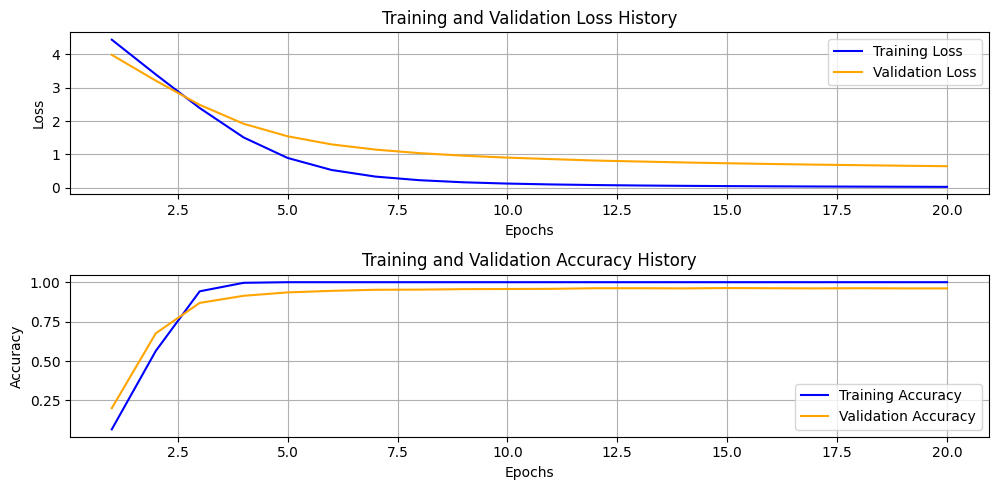

In [ ]:
# cell for plotting training and validation metrics
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'orange', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracy_history, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy_history, 'orange', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy History')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# evaluate on test dataset
test_model(model, test_loader)

Test Accuracy: 94.29%


## Analysis of Results
### The training and validation loss graphs show a significant decrease in loss over the epochs, with both curves stabilizing towards the end, indicating effective learning. The training accuracy increases steadily, while the validation accuracy also improves and closely matches the training accuracy, suggesting good generalization. The model achieved a test accuracy of 94.29%, demonstrating strong performance on the test set.